# Generalized Propensity Score (GPS), Causal Forest (CF), Orthogonal Forest (OF)

Prof. Daniel de Abreu Pereira Uhr

## Conteúdo

* Generalized Propensity Score (GPS)
* Causal Forest (CF) - Forest Double Machine Learning
* Orthogonal Forest (OF) - Orthogonal Random Forest

## Generalized Propensity Score (GPS)

O **Propensity Score (PS)** tradicional (Rosenbaum & Rubin, 1983) é definido para o caso de **tratamento binário**:

$$
e(X) = P(D=1 \mid X),
$$

onde (D \in {0,1}) indica se o indivíduo foi tratado e (X) representa as covariáveis.
O **Generalized Propensity Score (GPS)**, proposto por Hirano & Imbens (2004), estende esse conceito para o caso de **tratamentos contínuos ou multinomiais**.


Seja ($D \in \mathbb{R}$) uma variável de tratamento contínuo e ($X$) as covariáveis. O **GPS** é definido como a **densidade condicional** do tratamento dado os controles:

$$
r(d, X) = f_{D \mid X}(d \mid X),
$$

onde ($f_{D \mid X}$) é a função densidade condicional do tratamento.

***Propriedades Importantes***

1. **Independência Condicional Generalizada**:
   
   Dados ($r(D,X)$), o tratamento é independente das covariáveis ($X$). Isso generaliza a ideia de balanceamento do Propensity Score.

2. **Redução da Dimensão**:
   
   Assim como o PS tradicional reduz a dimensionalidade no caso binário, o GPS reduz a dimensionalidade no caso contínuo.

3. **Função Dose–Resposta**:
   
   O GPS permite estimar o **efeito causal médio para diferentes doses do tratamento**, isto é:

   $$
   \mu(d) = \mathbb{E}[Y(d)],
   $$

   onde ($Y(d)$) é o potencial outcome se o indivíduo recebesse intensidade de tratamento ($d$).


***Etapas do Estimador GPS (Hirano & Imbens, 2004)***

1. **Primeira Etapa – Estimar o GPS**
   
   Modelar ($D|X$). Exemplo: se ($D$) for contínuo aproximadamente normal, usar regressão normal:

   $$
   D = X\beta + \epsilon, \quad \epsilon \sim N(0, \sigma^2).
   $$

   O GPS é a densidade predita:

   $$
   \hat r(d, X) = \frac{1}{\hat\sigma} \phi\left( \frac{d - X\hat\beta}{\hat\sigma} \right),
   $$

   onde ($\phi$) é a densidade normal padrão.

2. **Segunda Etapa – Modelar ($Y$) em função de ($D$) e ($\hat r(D,X)$)**
   
   Regressão condicional:

   $$
   Y = \alpha_0 + \alpha_1 D + \alpha_2 D^2 + \alpha_3 \hat r(D,X) + \alpha_4 \hat r(D,X)^2 + \alpha_5 D \cdot \hat r(D,X) + u.
   $$

3. **Terceira Etapa – Estimar a Função Dose–Resposta**
   
   Para cada ($d$), calcular:

   $$
   \hat \mu(d) = \frac{1}{N} \sum_{i=1}^N \hat{\mathbb{E}}[Y \mid D=d, \hat r(d,X_i)].
   $$

   Isso fornece o **efeito médio do tratamento** para cada nível de dose ($d$).


In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

In [4]:
# DataFrame
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

In [5]:
df

,bweight,mmarried,mhisp,fhisp,foreign,alcohol,deadkids,mage,medu,fage,...,order,msmoke,mbsmoke,mrace,frace,prenatal,birthmonth,lbweight,fbaby,prenatal1
0,3459,married,0,0,0,0,0,24,14,28,...,2,0 daily,nonsmoker,1,1,1,12,0,No,Yes
1,3260,notmarried,0,0,1,0,0,20,10,0,...,3,0 daily,nonsmoker,0,0,1,7,0,No,Yes
2,3572,married,0,0,1,0,0,22,9,30,...,3,0 daily,nonsmoker,1,1,1,3,0,No,Yes
3,2948,married,0,0,0,0,0,26,12,30,...,2,0 daily,nonsmoker,1,1,1,1,0,No,Yes
4,2410,married,0,0,0,0,0,20,12,21,...,1,0 daily,nonsmoker,1,1,1,3,1,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,3317,notmarried,0,0,0,0,0,21,12,24,...,1,1-5 daily,smoker,1,1,2,10,0,Yes,No
4638,3030,married,0,0,0,1,1,30,12,23,...,2,11+ daily,smoker,1,1,2,2,0,No,No
4639,2950,notmarried,0,0,0,0,0,23,12,0,...,1,0 daily,nonsmoker,0,0,1,5,0,Yes,Yes
4640,3969,married,0,0,0,0,0,23,12,25,...,1,0 daily,nonsmoker,1,1,1,2,0,Yes,Yes


In [8]:
# Criar a variável de resultado
df['Y'] = df['bweight']

# Crie a variável 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodifique 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

df['casada'] = 0
df.loc[df['mmarried']=='married', 'casada'] = 1

# Conjunto de Covariáveis X
X = ['casada', 'mage', 'medu']

# garanta a ordem correta das categorias (se necessário)
order = ['0 daily', '1-5 daily', '6-10 daily', '11+ daily']
df['msmoke'] = pd.Categorical(df['msmoke'], categories=order, ordered=True)

# mapeamentos
map_mid = {
    '0 daily': 0,
    '1-5 daily': 3,
    '6-10 daily': 8,
    '11+ daily': 12  # ajuste se quiser um outro representativo (ex.: 15)
}
map_ord = {k: i for i, k in enumerate(order)}  # 0,1,2,3 (ordinal)

# variáveis de tratamento
df['T_cont'] = df['msmoke'].map(map_mid).astype(float) 

In [9]:
df

,bweight,mmarried,mhisp,fhisp,foreign,alcohol,deadkids,mage,medu,fage,...,prenatal,birthmonth,lbweight,fbaby,prenatal1,Y,Treated,casada,id,T_cont
0,3459,married,0,0,0,0,0,24,14,28,...,1,12,0,No,Yes,3459,0,1,1,0.0
1,3260,notmarried,0,0,1,0,0,20,10,0,...,1,7,0,No,Yes,3260,0,0,2,0.0
2,3572,married,0,0,1,0,0,22,9,30,...,1,3,0,No,Yes,3572,0,1,3,0.0
3,2948,married,0,0,0,0,0,26,12,30,...,1,1,0,No,Yes,2948,0,1,4,0.0
4,2410,married,0,0,0,0,0,20,12,21,...,1,3,1,Yes,Yes,2410,0,1,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,3317,notmarried,0,0,0,0,0,21,12,24,...,2,10,0,Yes,No,3317,1,0,4638,3.0
4638,3030,married,0,0,0,1,1,30,12,23,...,2,2,0,No,No,3030,1,1,4639,12.0
4639,2950,notmarried,0,0,0,0,0,23,12,0,...,1,5,0,Yes,Yes,2950,0,0,4640,0.0
4640,3969,married,0,0,0,0,0,23,12,25,...,1,2,0,Yes,Yes,3969,0,1,4641,0.0


In [10]:
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

# Definir variáveis
Y = df['Y'].values
T = df['T_cont'].values
X_vars = df[X].values  # ['casada','mage','medu']

# 1. Regressão T ~ X (modelo condicional do tratamento)
reg_T = LinearRegression().fit(X_vars, T)
mu_T = reg_T.predict(X_vars)          # média condicional E[T|X]
sigma_T = np.std(T - mu_T)            # desvio padrão dos resíduos

# 2. Calcular densidade condicional (GPS)
gps = norm.pdf(T, loc=mu_T, scale=sigma_T)
df['gps'] = gps


In [11]:
df

,bweight,mmarried,mhisp,fhisp,foreign,alcohol,deadkids,mage,medu,fage,...,birthmonth,lbweight,fbaby,prenatal1,Y,Treated,casada,id,T_cont,gps
0,3459,married,0,0,0,0,0,24,14,28,...,12,0,No,Yes,3459,0,1,1,0.0,0.112140
1,3260,notmarried,0,0,1,0,0,20,10,0,...,7,0,No,Yes,3260,0,0,2,0.0,0.081569
2,3572,married,0,0,1,0,0,22,9,30,...,3,0,No,Yes,3572,0,1,3,0.0,0.100852
3,2948,married,0,0,0,0,0,26,12,30,...,1,0,No,Yes,2948,0,1,4,0.0,0.107619
4,2410,married,0,0,0,0,0,20,12,21,...,3,1,Yes,Yes,2410,0,1,5,0.0,0.109499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,3317,notmarried,0,0,0,0,0,21,12,24,...,10,0,Yes,No,3317,1,0,4638,3.0,0.113936
4638,3030,married,0,0,0,1,1,30,12,23,...,2,0,No,No,3030,1,1,4639,12.0,0.001059
4639,2950,notmarried,0,0,0,0,0,23,12,0,...,5,0,Yes,Yes,2950,0,0,4640,0.0,0.087879
4640,3969,married,0,0,0,0,0,23,12,25,...,2,0,Yes,Yes,3969,0,1,4641,0.0,0.108590


vamos implementar o estimador clássico de **Hirano & Imbens (2004)** na tua base.

* ( Y = ) peso do bebê (`df['Y']`)
* ( T = ) intensidade contínua de cigarro fumado pela mãe (`df['T_cont']`)
* ( X = ) covariáveis (`casada`, `mage`, `medu`)
* ( r(T, X) = ) GPS calculado (`df['gps']`)

Agora seguimos os **passos 2 e 3 do método**:

***1. Regressão de ($Y$) em função de ($T$, $T^2$, $gps$, $gps^2$, $T \times gps$)***

$$
Y = \alpha_0 + \alpha_1 T + \alpha_2 T^2 + \alpha_3 gps + \alpha_4 gps^2 + \alpha_5 (T \cdot gps) + u
$$

***2. Estimar a função dose–resposta ($\hat \mu(d)$)***

Para cada nível ($d$) no grid de tratamento, fazemos:

$$
\hat\mu(d) = \frac{1}{N} \sum_{i=1}^N \hat{\mathbb{E}}[Y \mid T=d, gps=r(d, X_i)]
$$

Ou seja:

* Para cada indivíduo, calculamos o GPS correspondente ao nível (d).
* Preenchemos na regressão estimada.
* Tiramos a média da predição sobre toda a amostra.


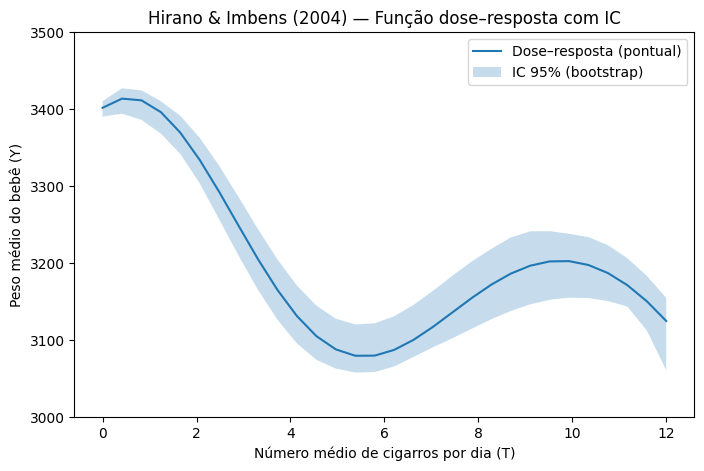

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from joblib import Parallel, delayed

# ------------------------------------------------------------
# Entradas principais
# df: DataFrame já contendo Y, T_cont, casada, mage, medu
# ------------------------------------------------------------

Y = df['Y'].to_numpy()
T = df['T_cont'].astype(float).to_numpy()
X_cov = df[['casada','mage','medu']].to_numpy()

# ---------- Funções auxiliares ----------

def fit_T_on_X(T, X_cov):
    reg_T = LinearRegression().fit(X_cov, T)
    mu_T = reg_T.predict(X_cov)
    sigma_T = np.std(T - mu_T, ddof=1)
    # Evitar sigma ~ 0 (numérico)
    sigma_T = max(sigma_T, 1e-8)
    return mu_T, sigma_T

def fit_Y_on_Tgps(Y, T, gps):
    X_reg = np.column_stack([T, T**2, gps, gps**2, T*gps])
    reg_y = LinearRegression().fit(X_reg, Y)
    return reg_y

def predict_mu_of_d(d, reg_y, mu_T, sigma_T):
    gps_d = norm.pdf(d, loc=mu_T, scale=sigma_T)
    X_pred = np.column_stack([
        np.repeat(d, len(mu_T)),
        np.repeat(d**2, len(mu_T)),
        gps_d, gps_d**2, d*gps_d
    ])
    return np.mean(reg_y.predict(X_pred))

def estimate_dose_response(df, d_grid):
    # 1) T|X -> GPS
    Y = df['Y'].to_numpy()
    T = df['T_cont'].astype(float).to_numpy()
    X_cov = df[['casada','mage','medu']].to_numpy()

    mu_T, sigma_T = fit_T_on_X(T, X_cov)
    gps = norm.pdf(T, loc=mu_T, scale=sigma_T)

    # 2) Y ~ T, T^2, gps, gps^2, T*gps
    reg_y = fit_Y_on_Tgps(Y, T, gps)

    # 3) μ(d)
    mu_hat = np.array([predict_mu_of_d(d, reg_y, mu_T, sigma_T) for d in d_grid])
    return mu_hat

# ---------- Estimativa pontual ----------
d_grid = np.linspace(np.nanmin(T), np.nanmax(T), 30)
mu_point = estimate_dose_response(df, d_grid)

# ---------- Bootstrap (percentil) ----------
B = 300
rng = np.random.default_rng(12345)

def one_bootstrap(b):
    idx = rng.integers(0, len(df), size=len(df))
    df_b = df.iloc[idx].reset_index(drop=True)
    # Garantir tipos/ordens se necessário:
    df_b['casada'] = df_b['casada'].astype(int)
    df_b['mage'] = pd.to_numeric(df_b['mage'], errors='coerce')
    df_b['medu'] = pd.to_numeric(df_b['medu'], errors='coerce')
    df_b['T_cont'] = pd.to_numeric(df_b['T_cont'], errors='coerce')
    df_b = df_b.dropna(subset=['Y','T_cont','casada','mage','medu'])
    return estimate_dose_response(df_b, d_grid)

# Paralelize se desejar (n_jobs=-1 usa todos os núcleos)
boot_mat = Parallel(n_jobs=-1, prefer="processes")(
    delayed(one_bootstrap)(b) for b in range(B)
)
boot_mat = np.vstack(boot_mat)   # shape: (B, len(d_grid))

# IC 95% (percentis)
lower = np.nanpercentile(boot_mat, 2.5, axis=0)
upper = np.nanpercentile(boot_mat, 97.5, axis=0)

# ---------- Plot ----------
plt.figure(figsize=(8,5))
plt.plot(d_grid, mu_point, label="Dose–resposta (pontual)")
plt.fill_between(d_grid, lower, upper, alpha=0.25, label="IC 95% (bootstrap)")
plt.xlabel("Número médio de cigarros por dia (T)")
plt.ylabel("Peso médio do bebê (Y)")
plt.title("Hirano & Imbens (2004) — Função dose–resposta com IC")
plt.ylim(3000, 3500) 
plt.legend()
plt.show()


Vamos aplicar com splines

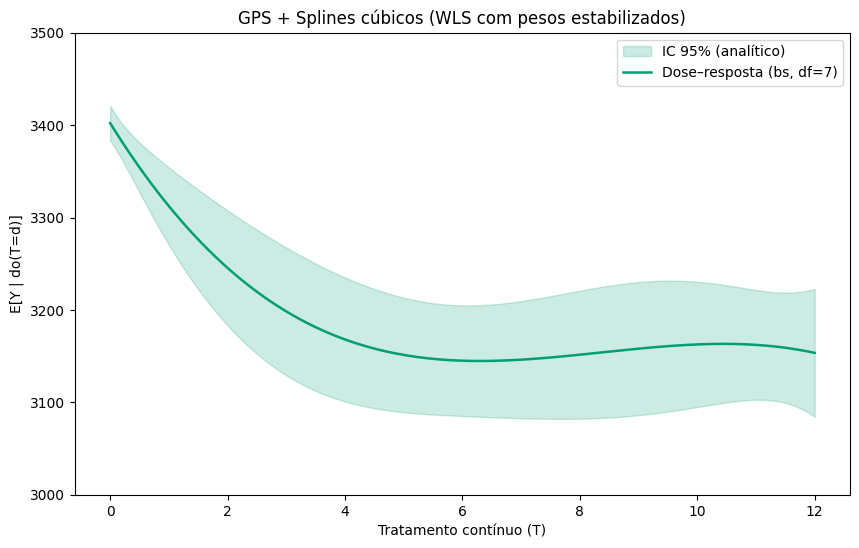

In [35]:
# ============================================================
# GPS + Splines cúbicos (bs) com ICs analíticos (sem bootstrap)
# WLS ponderado por pesos estabilizados: f_T(T)/f_{T|X}(T|X)
# Opcional: covariância HC3 (default) ou cluster-robusta
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix, build_design_matrices
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, gaussian_kde

# ------------------- PARÂMETROS -------------------
DF_SPLINE       =  7                # flexibilidade da spline (ajuste se quiser)
TRIM_WEIGHTS    = (1, 99)           # truncagem dos pesos estabilizados
USE_CLUSTEREDSE = False             # True se quiser SEs clusterizados
CLUSTER_COL     = 'i'               # coluna de cluster (se USE_CLUSTEREDSE=True)

# ------------------- PREP -------------------
df_ = df[['Y','T_cont','casada','mage','medu']].dropna().copy()
Y   = df_['Y'].to_numpy()
T   = df_['T_cont'].astype(float).to_numpy()
Xc  = df_[['casada','mage','medu']].to_numpy(dtype=float)

# ------------------- 1) Pesos estabilizados -------------------
# f_{T|X} normal condicional
reg_T = LinearRegression().fit(Xc, T)
mu_T  = reg_T.predict(Xc)
sigma = np.std(T - mu_T, ddof=1)
sigma = max(sigma, 1e-8)
f_T_given_X = norm.pdf(T, loc=mu_T, scale=sigma)

# f_T marginal via KDE
kde = gaussian_kde(T)
f_T = kde.evaluate(T)

w = f_T / f_T_given_X
lo, hi = np.nanpercentile(w, TRIM_WEIGHTS)
w = np.clip(w, lo, hi)

mask = np.isfinite(Y) & np.isfinite(T) & np.isfinite(w)
Y, T, w = Y[mask], T[mask], w[mask]
if USE_CLUSTEREDSE:
    clusters = df_.loc[mask, CLUSTER_COL].to_numpy()

# ------------------- 2) Base de spline cúbica (bs) -------------------
# df controla a flexibilidade; knots automáticos por quantis internos
B_T = dmatrix(f"bs(T, df={DF_SPLINE}, degree=3, include_intercept=True) - 1",
              {"T": T}, return_type='dataframe')
design_info = B_T.design_info

# ------------------- 3) WLS com SEs robustos -------------------
mod = sm.WLS(Y, B_T, weights=w)
if USE_CLUSTEREDSE:
    res = mod.fit(cov_type='cluster', cov_kwds={'groups': clusters})
else:
    res = mod.fit()
    # robustez a heterocedasticidade
    res = res.get_robustcov_results(cov_type='HC3')

beta = res.params
V    = res.cov_params()

# ------------------- 4) Curva dose–resposta + IC analítico -------------------
t_lo, t_hi = np.percentile(T, [2, 98])
t_grid = np.linspace(t_lo, t_hi, 200)

def spline_row(d, design_info):
    Xd = build_design_matrices([design_info], {"T": np.array([d])})[0]
    return np.asarray(Xd)[0]

Xpred  = np.vstack([spline_row(d, design_info) for d in t_grid])  # (G x p)
mu_hat = Xpred @ beta
se     = np.sqrt(np.sum(Xpred @ V * Xpred, axis=1))                # diag(X V X')
z      = 1.96
lower  = mu_hat - z*se
upper  = mu_hat + z*se

# ------------------- 5) Plot -------------------
plt.figure(figsize=(10,6))
plt.fill_between(t_grid, lower, upper, alpha=0.20, color="#009E73", label="IC 95% (analítico)")
plt.plot(t_grid, mu_hat, color="#009E73", linewidth=1.8, label=f"Dose–resposta (bs, df={DF_SPLINE})")
plt.axhline(0, color="black", linestyle="dotted", linewidth=0.6)
plt.xlabel("Tratamento contínuo (T)")
plt.ylabel("E[Y | do(T=d)]")
plt.title("GPS + Splines cúbicos (WLS com pesos estabilizados)")
plt.legend()
plt.ylim(3000, 3500) 
plt.grid(False)
plt.show()
